# Imports

In [5]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt


# Variables

In [6]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (160, 160)
SEED = 42

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

# Setup Dataset

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


# View Some Images

In [8]:
class_names = train_ds.class_names

plt.figure(figsize=(15, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(class_names[labels[i]])
#    plt.axis("off")

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# AutoTune Dataset

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [10]:
# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        #tf.keras.layers.GaussianNoise(0.2),
    ]
)

## View Augmented Images

2024-10-18 17:33:53.175096: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


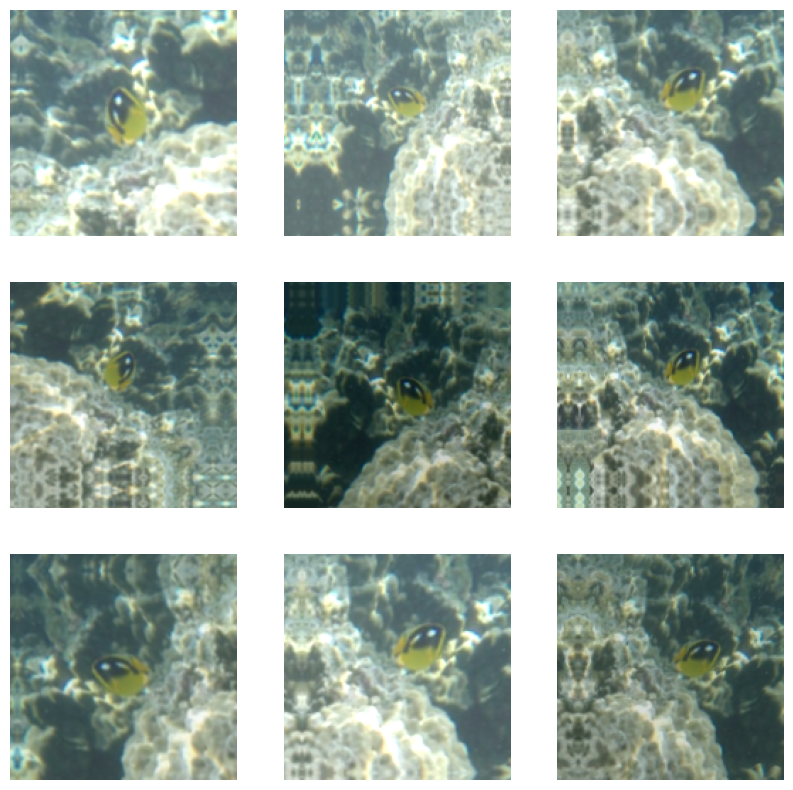

In [11]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# MobileNetV2 Image Preprocessing
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

# Create Base Model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [14]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs) 
x = preprocess_input(x) 
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(57, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 5, 5, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 57)             │       116,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,681,593 (90.34 MB)

 Trainable params: 116,793 (456.22 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [16]:
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2024-10-18 17:33:55.687369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.0328 - loss: 5.4326
initial loss: 5.44
initial accuracy: 0.03


In [17]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.0632 - loss: 4.8027 - val_accuracy: 0.2452 - val_loss: 3.0587
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.2314 - loss: 3.1379 - val_accuracy: 0.4081 - val_loss: 2.2658
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.3682 - loss: 2.4122 - val_accuracy: 0.5028 - val_loss: 1.8641
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.4344 - loss: 2.0681 - val_accuracy: 0.5725 - val_loss: 1.6205
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5222 - loss: 1.8005 - val_accuracy: 0.6133 - val_loss: 1.4705
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.5459 - loss: 1.6545 - val_accuracy: 0.6402 - val_loss: 1.3492
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.5822 - loss: 1.5207 - val_accuracy: 0.6581 - val_loss: 1.2733
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.6052 - loss: 1

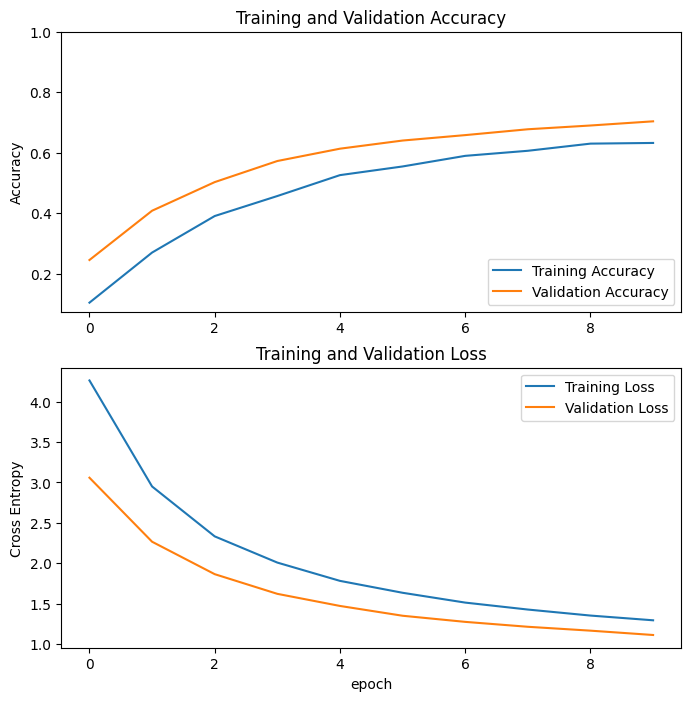

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [19]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [20]:
model.compile(
  optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  loss="categorical_crossentropy", 
  metrics=['accuracy'],
)

In [21]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 54s 233ms/step - accuracy: 0.5409 - loss: 1.8536 - val_accuracy: 0.7030 - val_loss: 1.1253
Epoch 12/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.6483 - loss: 1.3444 - val_accuracy: 0.7265 - val_loss: 1.0241
Epoch 13/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.7109 - loss: 1.1157 - val_accuracy: 0.7535 - val_loss: 0.9198
Epoch 14/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 212ms/step - accuracy: 0.7393 - loss: 0.9755 - val_accuracy: 0.7762 - val_loss: 0.8397
Epoch 15/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.7607 - loss: 0.8882 - val_accuracy: 0.8004 - val_loss: 0.7685
Epoch 16/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.7827 - loss: 0.8178 - val_accuracy: 0.8011 - val_loss: 0.7315
Epoch 17/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.8120 - loss: 0.7005 - val_accuracy: 0.8170 - val_loss: 0.6835
Epoch 18/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.8199 -

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

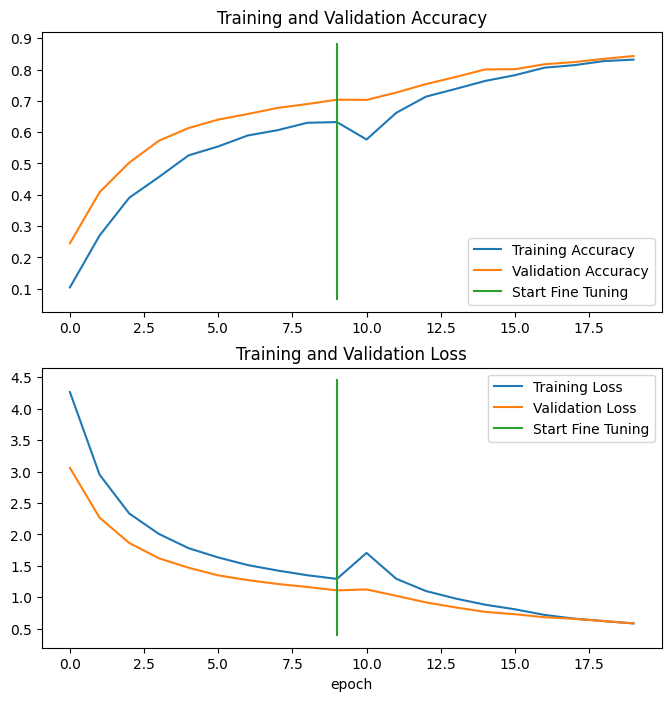

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8350 - loss: 0.5947
Test accuracy : 0.8325966596603394
